<a href="https://colab.research.google.com/github/ndautukwabala-lab/energy-data-engineering/blob/ndautukwabala-lab-patch-1/CNN_Pnuemonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
# 0. Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

print(tf.__version__)


2.19.0


In [ ]:
# 1. Paths (using the path from kagglehub)
data_dir = os.path.join(path, "chest_xray")

train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")
test_dir  = os.path.join(data_dir, "test")

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Test dir:", test_dir)



Train dir: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Val dir: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Test dir: /kaggle/input/chest-xray-pneumonia/chest_xray/test


In [ ]:
# 2. Dataset parameters
img_size = (224, 224)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# 3. Load datasets using image_dataset_from_directory

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']


In [ ]:
# 4. Basic EDA: count images per class in train set
train_counts = {name: 0 for name in class_names}

for batch_images, batch_labels in train_ds:
    for label in batch_labels.numpy().astype(int):
        label = int(label.item())  # convert array to scalar
        train_counts[class_names[label]] += 1

train_counts


{'NORMAL': 1341, 'PNEUMONIA': 3875}

/tmp/ipython-input-3303773497.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"{class_names[int(labels[i].numpy())]}")


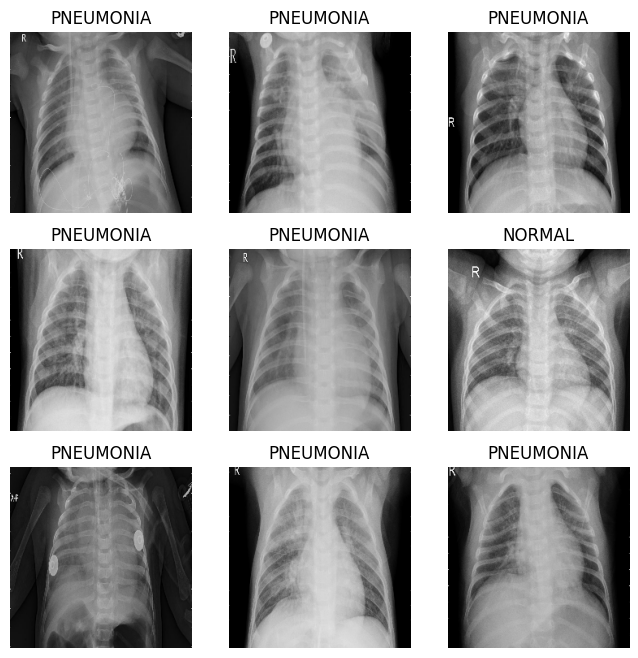

In [ ]:
# 5. Visualise a few sample images
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[int(labels[i].numpy())]}")
        plt.axis("off")


In [ ]:
# 6. Performance optimisations + preprocessing
# Cache & prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing layer (rescale + DenseNet preprocess)
preprocess_layer = tf.keras.Sequential(
    [
        layers.Rescaling(1./255),
        layers.Lambda(preprocess_input)
    ],
    name="preprocessing"
)


In [ ]:
# 7. Build Transfer Learning CNN (DenseNet121 backbone)

base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)

base_model.trainable = False  # freeze base model at first

inputs = layers.Input(shape=img_size + (3,))
x = preprocess_layer(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs, name="pneumonia_cnn_densenet")

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "pneumonia_cnn_densenet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
# 8. Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)


In [ ]:
# 9. Train model (frozen base)
initial_epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 977s 6s/step - accuracy: 0.6935 - auc: 0.5595 - loss: 0.5927 - precision: 0.7455 - recall: 0.8856 - val_accuracy: 0.5000 - val_auc: 0.8750 - val_loss: 0.7571 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 919s 6s/step - accuracy: 0.7587 - auc: 0.7618 - loss: 0.4979 - precision: 0.7585 - recall: 0.9909 - val_accuracy: 0.5000 - val_auc: 0.8594 - val_loss: 0.7569 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 922s 6s/step - accuracy: 0.7796 - auc: 0.8468 - loss: 0.4380 - precision: 0.7864 - recall: 0.9682 - val_accuracy: 0.5625 - val_auc: 0.8594 - val_loss: 0.7296 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 916s 6s/step - accuracy: 0.8159 - auc: 0.8800 - loss: 0.3912 - precision: 0.8267 - recall: 0.9533 - val_accuracy: 0.6250 - val_auc: 0.8594 - val_loss: 0.7221 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/5
163/163 ━━━━━━━━━━━━━━

In [ ]:
# 10. Fine-tune last layers of DenseNet for better accuracy

base_model.trainable = True

# Freeze most layers and leave last N trainable
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

fine_tune_epochs = 5  # also adjustable
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1
)


Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1178s 7s/step - accuracy: 0.8385 - auc: 0.7935 - loss: 1.4793 - precision: 0.8499 - recall: 0.9584 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 5.2545 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1144s 7s/step - accuracy: 0.9437 - auc: 0.9830 - loss: 0.1575 - precision: 0.9650 - recall: 0.9595 - val_accuracy: 0.5000 - val_auc: 0.5625 - val_loss: 5.9175 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1144s 7s/step - accuracy: 0.9611 - auc: 0.9862 - loss: 0.1244 - precision: 0.9730 - recall: 0.9747 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 1.6515 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1169s 7s/step - accuracy: 0.9650 - auc: 0.9863 - loss: 0.1168 - precision: 0.9749 - recall: 0.9783 - val_accuracy: 0.6250 - val_auc: 0.8750 - val_loss: 1.9104 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 10/10
163/163 ━━━━

In [ ]:
 # 11. Evaluate on test set
test_results = model.evaluate(test_ds)
print("Test results (loss, acc, AUC, precision, recall):")
print(test_results)


20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step - accuracy: 0.5044 - auc: 0.5045 - loss: 4.5334 - precision: 0.3500 - recall: 0.6644
Test results (loss, acc, AUC, precision, recall):
[2.504162311553955, 0.7355769276618958, 0.7550843954086304, 0.7034357786178589, 0.9974358677864075]


In [ ]:
# 12. Confusion matrix + classification report

# Collect true labels
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy().astype(int))

y_true = np.array(y_true)

# Predictions
y_pred_probs = model.predict(test_ds).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step
Confusion matrix:
 [[ 70 164]
 [  1 389]]

Classification report:

              precision    recall  f1-score   support

      NORMAL       0.99      0.30      0.46       234
   PNEUMONIA       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624



In [ ]:
# 13. Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="True label",
        xlabel="Predicted label",
        title="Confusion Matrix"
    )

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()


In [ ]:
fig = plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, class_names)
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.close()


<Figure size 400x400 with 0 Axes>

In [ ]:
# Accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.title("Training Accuracy")
plt.savefig("train_accuracy.png", dpi=300, bbox_inches="tight")
plt.close()

# Loss curve
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.title("Training Loss")
plt.savefig("train_loss.png", dpi=300, bbox_inches="tight")
plt.close()


In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
    plt.savefig("sample_xrays.png", dpi=300, bbox_inches="tight")
    plt.close()


/tmp/ipython-input-3216711061.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(labels[i].numpy())])
